In [1]:
%reset -f

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


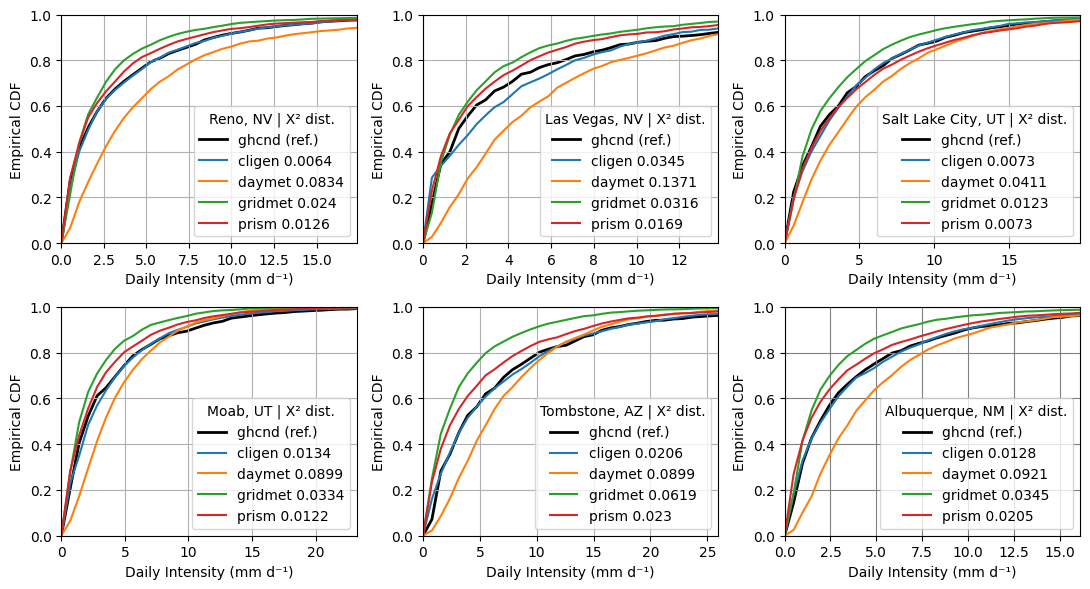

In [5]:

import pandas as pd
import numpy as np
import scipy
from scipy.spatial import distance
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import os
from decimal import Decimal

dataDIR = '/content/drive/My Drive/Colab Notebooks/GHCNd'


def chi2_distance(A, B):
  chi = 0.5 * np.sum([((a - b)**2) / (a + b)
                    for (a, b) in zip(A, B)])
  return chi

lvlOneFolders = ['rn', 'lv', 'sl', 'mb', 'tb', 'ab']
labels = ['Reno, NV', 'Las Vegas, NV', 'Salt Lake City, UT', 'Moab, UT', 'Tombstone, AZ', 'Albuquerque, NM']

fig, axs = plt.subplots(2, 3, figsize=(11, 6))
plt.rcParams['axes.grid'] = True

ax_inds = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]]
for i, ax in enumerate(axs.reshape(-1)):

  lvlOneFolder = lvlOneFolders[i]

  files = os.listdir(os.path.join(dataDIR, lvlOneFolder))

  for f in files:
    if '_cligen.csv' in f:
      cligen_file = f
    elif '_ghcnd.csv' in f:
      ghcnd_file = f
    elif '_daymet.csv' in f:
      daymet_file = f
    elif '_gridmet.csv' in f:
      gridmet_file = f
    elif '_prism.csv' in f:
      prism_file = f
    elif '_maca.csv' in f:
      maca_file = f
    else:
      pass

  with open(os.path.join(dataDIR, lvlOneFolder, cligen_file)) as f:
    lines = f.readlines()
    p = [float(l.split()[3]) for l in lines[15:-1] if float(l.split()[3]) > 0.0]
    cligen_p = p

  with open(os.path.join(dataDIR, lvlOneFolder, ghcnd_file)) as f:
    lines = f.readlines()
    p = [float(l.split(',')[4]) for l in lines[1:] if float(l.split(',')[4]) > 0.0]
    ghcnd_p = p

  with open(os.path.join(dataDIR, lvlOneFolder, daymet_file)) as f:
    lines = f.readlines()
    p = [float(l.split(',')[1]) for l in lines[1:] if float(l.split(',')[1]) > 0.0]
    daymet_p = p

  with open(os.path.join(dataDIR, lvlOneFolder, gridmet_file)) as f:
    lines = f.readlines()
    p = [float(l.split(',')[1]) for l in lines[1:] if float(l.split(',')[1]) > 0.0]
    gridmet_p = p

  with open(os.path.join(dataDIR, lvlOneFolder, prism_file)) as f:
    lines = f.readlines()
    p = [float(l.split(',')[1]) for l in lines[1:] if float(l.split(',')[1]) > 0.0]
    prism_p = p

  #with open(os.path.join(dataDIR, lvlOneFolder, maca_file)) as f:
  #  lines = f.readlines()
  #  p = [float(l.split(',')[1]) for l in lines[1:] if float(l.split(',')[1]) > 0.0]
  #  maca_p = p

  max_value = max(max(cligen_p), max(ghcnd_p), max(daymet_p), max(gridmet_p), max(prism_p))
  min_value = min(min(cligen_p), min(ghcnd_p), min(daymet_p), min(gridmet_p), min(prism_p))

  bins_pdf = np.linspace(min_value, max_value, 51)

  cligen_h = np.array(np.histogram(cligen_p, bins_pdf)[0], float)
  ghcnd_h = np.array(np.histogram(ghcnd_p, bins_pdf)[0], float)
  daymet_h = np.array(np.histogram(daymet_p, bins_pdf)[0], float)
  gridmet_h = np.array(np.histogram(gridmet_p, bins_pdf)[0], float)
  prism_h = np.array(np.histogram(prism_p, bins_pdf)[0], float)
  #maca_h = np.array(np.histogram(maca_p, bins_pdf)[0], float)

  cligen_h[cligen_h == 0] = 1e-9
  ghcnd_h[ghcnd_h == 0] = 1e-9
  daymet_h[daymet_h == 0] = 1e-9
  gridmet_h[gridmet_h == 0] = 1e-9
  prism_h[prism_h == 0] = 1e-9
  #maca_h[maca_h == 0] = 1e-9

  cligen_pdf = np.array([count/len(cligen_p) for i, count in enumerate(cligen_h)])
  ghcnd_pdf = np.array([count/len(ghcnd_p) for i, count in enumerate(ghcnd_h)])
  daymet_pdf = np.array([count/len(daymet_p) for i, count in enumerate(daymet_h)])
  gridmet_pdf = np.array([count/len(gridmet_p) for i, count in enumerate(gridmet_h)])
  prism_pdf = np.array([count/len(prism_p) for i, count in enumerate(prism_h)])
  #maca_pdf = np.array([count/len(maca_p) for i, count in enumerate(maca_h)])

  cligen_dev = round(chi2_distance(ghcnd_pdf, cligen_pdf), 4)
  daymet_dev = round(chi2_distance(ghcnd_pdf, daymet_pdf), 4)
  gridmet_dev = round(chi2_distance(ghcnd_pdf, gridmet_pdf), 4)
  prism_dev = round(chi2_distance(ghcnd_pdf, prism_pdf), 4)
  #maca_dev = round(chi2_distance(ghcnd_pdf, maca_pdf), 4)

  bins_cdf = np.linspace(min_value, max_value, 101)

  cligen_h = np.array(np.histogram(cligen_p, bins_cdf)[0], float)
  ghcnd_h = np.array(np.histogram(ghcnd_p, bins_cdf)[0], float)
  daymet_h = np.array(np.histogram(daymet_p, bins_cdf)[0], float)
  gridmet_h = np.array(np.histogram(gridmet_p, bins_cdf)[0], float)
  prism_h = np.array(np.histogram(prism_p, bins_cdf)[0], float)
  #maca_h = np.array(np.histogram(maca_p, bins_cdf)[0], float)

  cligen_cdf = np.array([0.0] + [sum(cligen_h[:i+1])/len(cligen_p) for i, value in enumerate(cligen_h)])
  ghcnd_cdf = np.array([0.0] + [sum(ghcnd_h[:i+1])/len(ghcnd_p) for i, value in enumerate(ghcnd_h)])
  daymet_cdf = np.array([0.0] + [sum(daymet_h[:i+1])/len(daymet_p) for i, value in enumerate(daymet_h)])
  gridmet_cdf = np.array([0.0] + [sum(gridmet_h[:i+1])/len(gridmet_p) for i, value in enumerate(gridmet_h)])
  prism_cdf = np.array([0.0] + [sum(prism_h[:i+1])/len(prism_p) for i, value in enumerate(prism_h)])
  #maca_cdf = np.array([0.0] + [sum(maca_h[:i+1])/len(maca_p) for i, value in enumerate(maca_h)])

  ghcnd, = ax.plot(bins_cdf, ghcnd_cdf, color='black', linewidth=2, zorder=-999)
  cligen, = ax.plot(bins_cdf, cligen_cdf)
  daymet, = ax.plot(bins_cdf, daymet_cdf)
  gridmet, = ax.plot(bins_cdf, gridmet_cdf)
  prism, = ax.plot(bins_cdf, prism_cdf)
  #maca, = ax.plot(bins_cdf, maca_cdf)

  ax.legend([ghcnd, cligen, daymet, gridmet, prism], ['ghcnd (ref.)', 'cligen {}'.format(str(cligen_dev)), 'daymet {}'.format(str(daymet_dev)), 'gridmet {}'.format(str(gridmet_dev)), 'prism {}'.format(str(prism_dev))], loc='lower right', title=labels[i] + ' | X² dist.')
  ax.set_xlim(0, 0.33*max_value)
  ax.set_ylim(0, 1)
  ax.set_ylabel('Empirical CDF')
  ax.set_xlabel('Daily Intensity (mm d⁻¹)')

ax.grid(color='gray')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(dataDIR, 'cdf_figure.jpg'), bbox_inches='tight', pad_inches=0.25, dpi=600)


